# TensorFlow Course
---


In [1]:
# Installing TensorFlow datsets
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Importing Tensorflow
import tensorflow as tf

In [2]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Omly log error messages or higher in TensorFlow
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [17]:
# Load the fashion_mnist dataset as supervised datset
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
# Then split dataset into train and test datasets
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [5]:
# Adding names to columns (Labeling)
class_names = metadata.features['label'].names
print(metadata.features['label'].names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Explore the data

In [10]:
# Exploring the data
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

# Printing the values
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## 60000 Images used for training and 10000 images using for testing the neural network

### Preprocessing the Data

In [15]:
# In here dataset is normalizing

# This function do the normalization
def normalize(images, labels):
  # Cast values of pixel to the float values
  images = tf.cast(images, tf.float32)
  # Then devide by 255 (Because it is the maximum value of a pixel)
  images /= 255
  # return image and label
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Explore the processed data

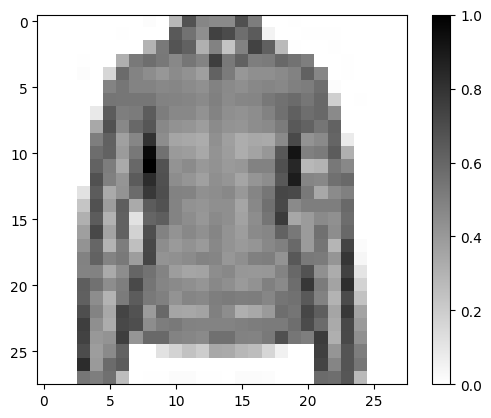

In [14]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

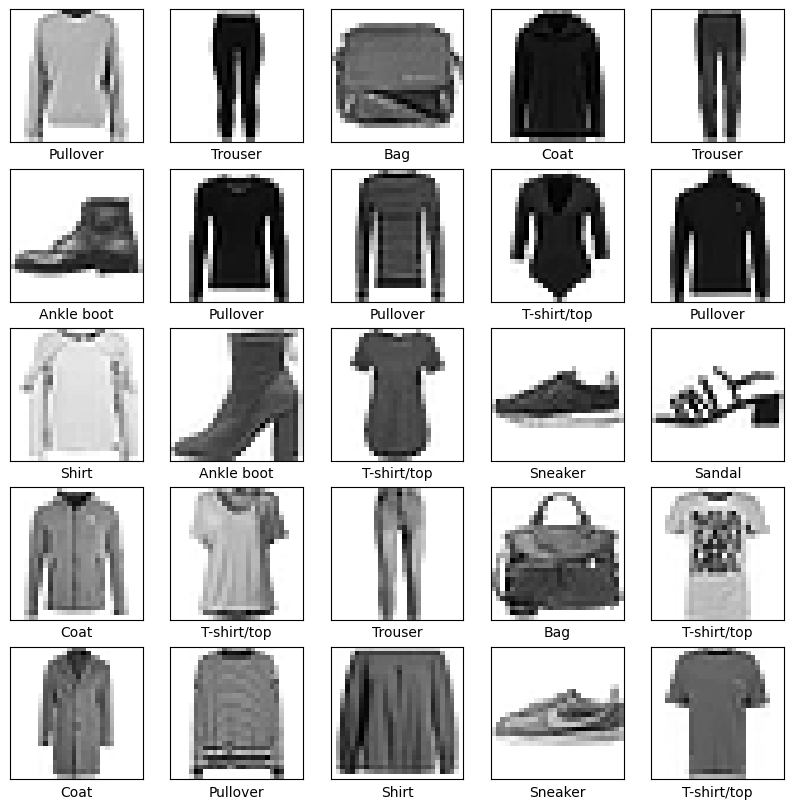

In [16]:
# Plot first 25 examples in training dataset
# Initialize the dataset
plt.figure(figsize=(10,10))

# Take first 25 images and labels and index
for i, (image, label) in enumerate(train_dataset.take(25)):
    # Converting tensor into the numpy array and reshape to 28x28 pixel image
    image = image.numpy().reshape((28,28))
    # Access the subplot
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Showing the image
    plt.imshow(image, cmap=plt.cm.binary)
    # Label as the label w got from metadata
    plt.xlabel(class_names[label])

# Showing the results
plt.show()

## Buliding the model

In [21]:
# Bulding the seqential model using dense layers
# Using ReLU as activation function (Best for non-linear algos)
# Softmax has chosen for output activation function

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

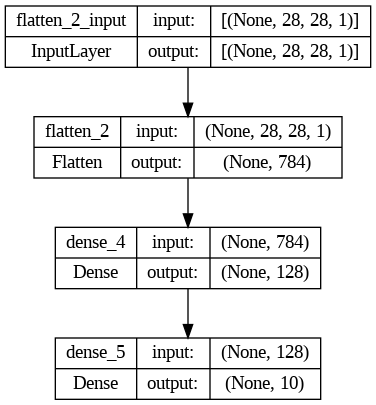

In [22]:
# Plot the built model
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Comple the model

In [23]:
# Adam Optimizer is used
# Loss functions for classification is selected as sparse_categorical_crossentropy
# And the perfromance is evaluated on the accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Train the model

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

In [24]:
# To train the model batch size should be defined
# In this case it is 32
BATCH_SIZE = 32

# Train dataset
# Caches use for faster training
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
# Test dataset
test_dataset = test_dataset.cache().batch(BATCH_SIZE)


In [25]:
# Fit the model
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 16s 3ms/step - loss: 0.4962 - accuracy: 0.8267
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3720 - accuracy: 0.8656
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3338 - accuracy: 0.8790
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3099 - accuracy: 0.8861
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2954 - accuracy: 0.8917


## **Evaluate the model performance**

In [26]:
# Evaluate accuracy of the model.
# Steps is equal to int(60000/32)
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.3424 - accuracy: 0.8782
Accuracy on test dataset: 0.8781999945640564


##  **Prediction**

In [20]:
# Get the test image and labels from the test dataset
# In above test dataset is set to batchsize of 32
# Therefore, in one take 32 images and labels included

for test_images, test_labels in test_dataset.take(1):
  # Reshaping tensor to numerical values
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  # Predict with 32 images
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 71ms/step


In [28]:
# View the shape of prediction
predictions.shape

(32, 10)

#### That means every image has 10 probabilities and there are 32 images. therefore prediction is 32x10 2D array.

In [29]:
# View predictions of 1st image
predictions[0]

array([6.4187254e-05, 4.3597865e-06, 3.3159968e-02, 5.5173546e-06,
       9.1514391e-01, 1.8070645e-08, 5.1607497e-02, 4.2202810e-08,
       1.4553133e-05, 2.5123983e-09], dtype=float32)

In [30]:
# So we can get the index of the max probabilty
index = np.argmax(predictions[0])
print(f"{index} and the type is {class_names[index]}")

4 and the type is Coat


In [31]:
# Check with the label of test set
test_labels[0]

4

In [32]:
# Graph predictions
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

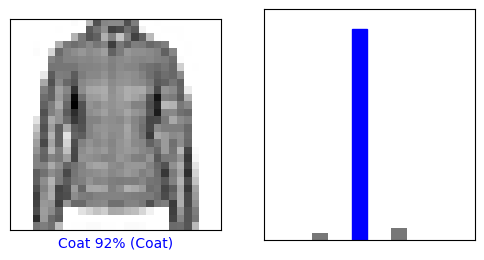

In [33]:
# Verifying 1st test
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

<ipython-input-35-39dff5ecb79f>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,3))


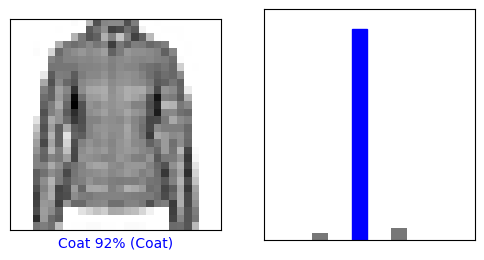

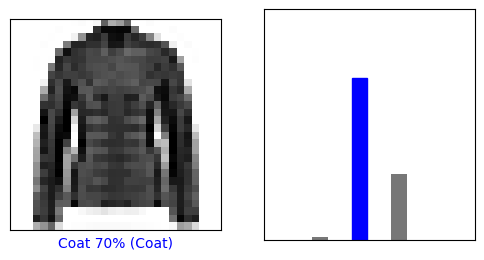

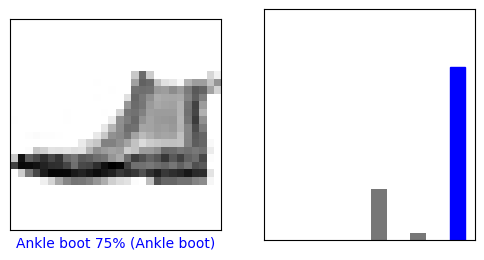

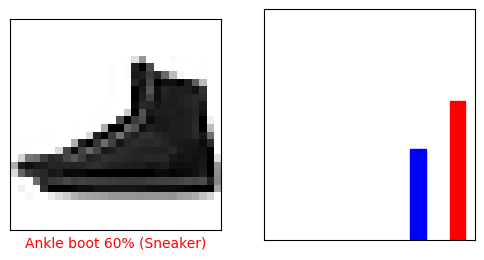

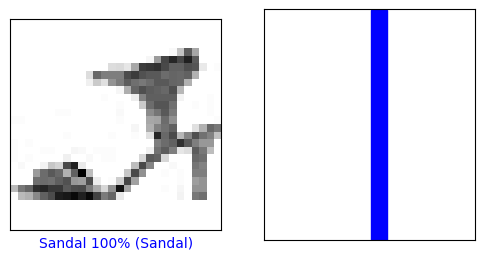

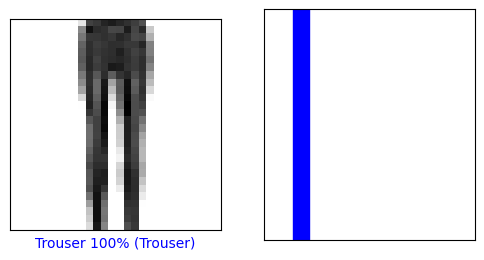

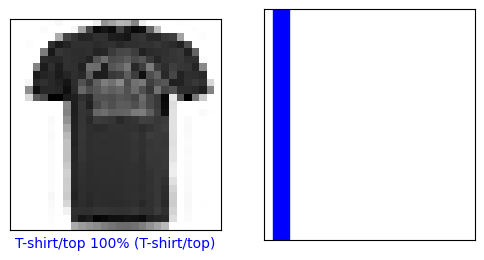

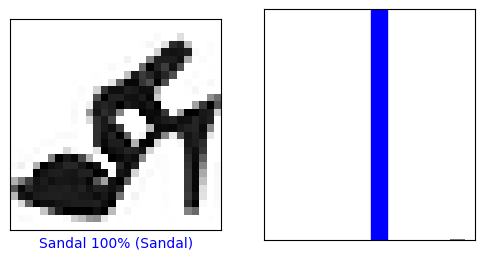

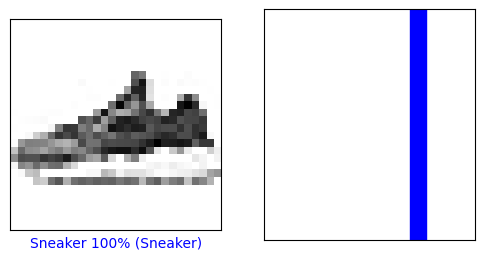

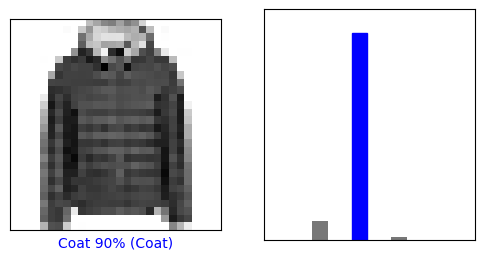

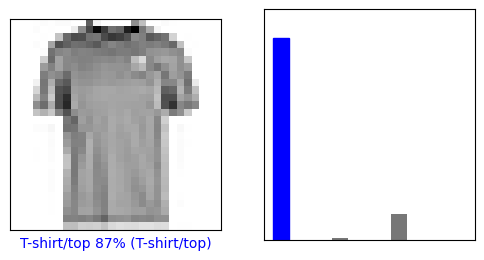

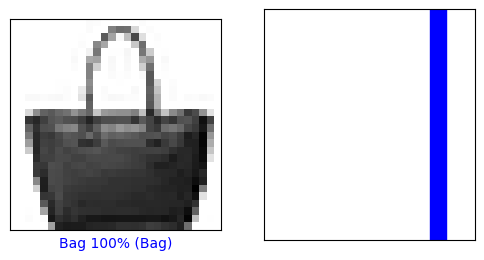

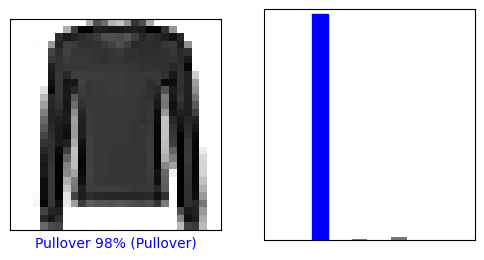

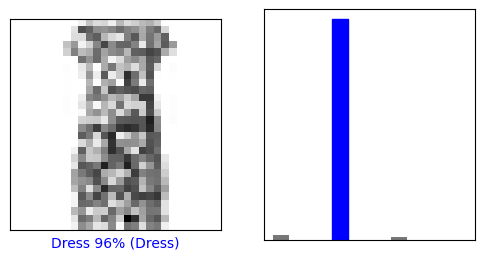

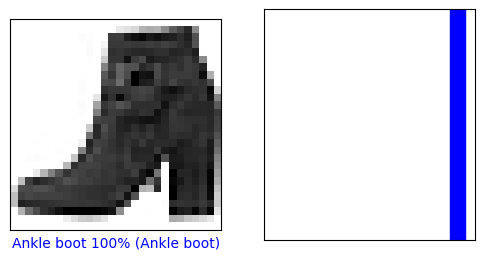

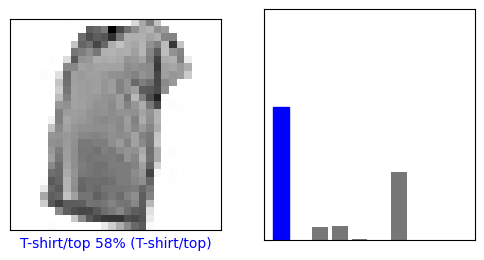

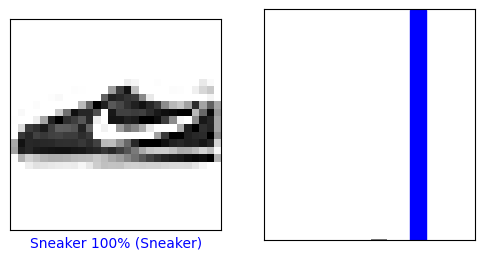

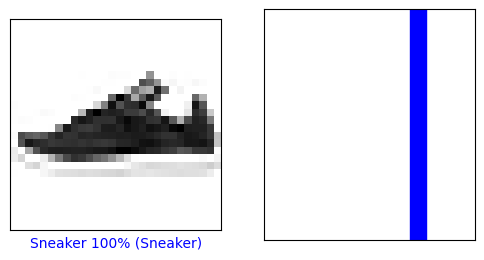

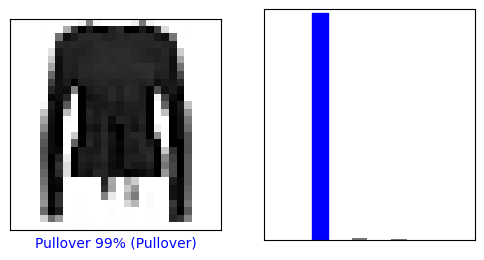

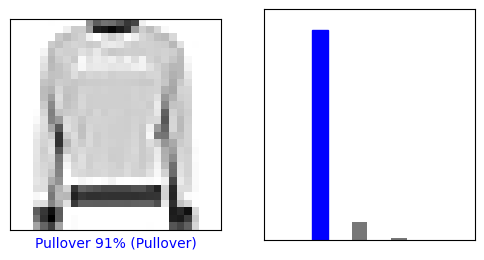

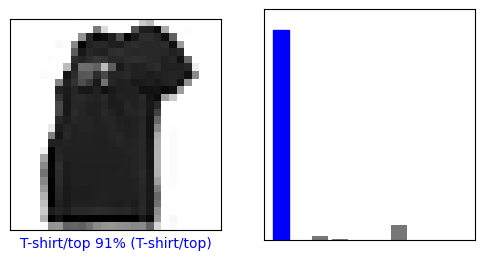

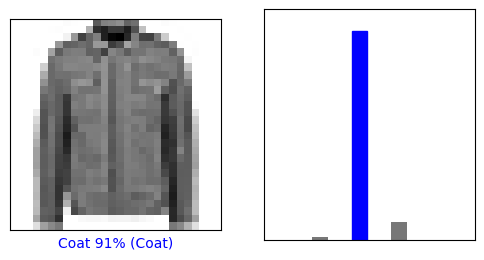

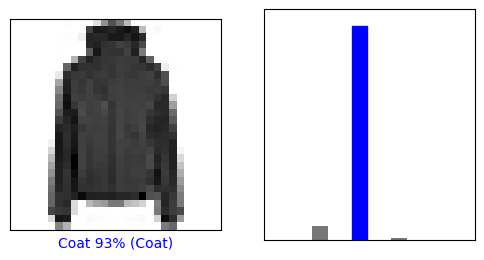

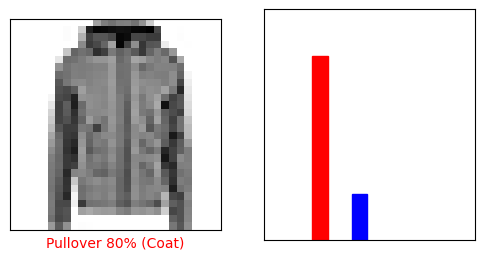

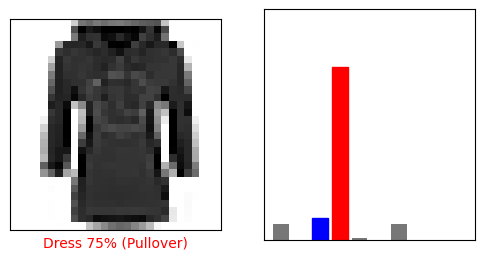

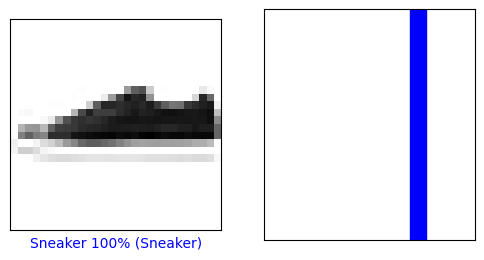

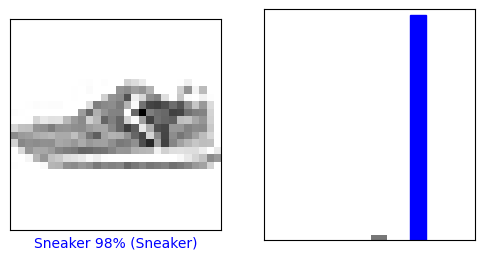

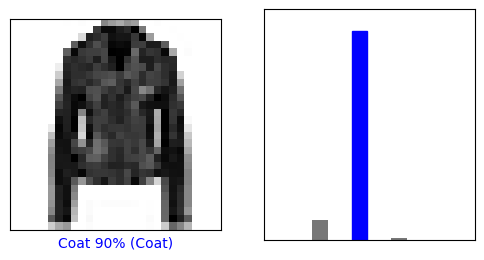

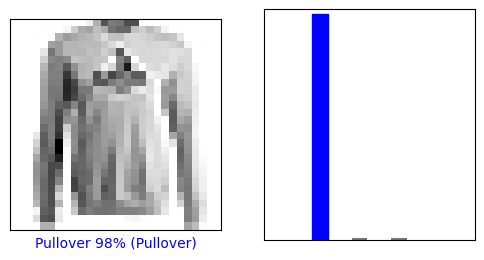

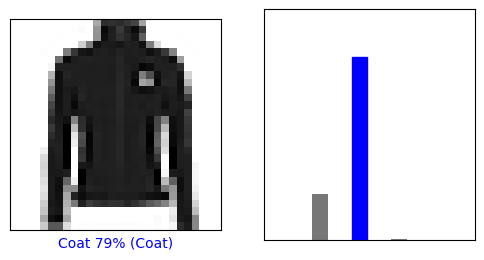

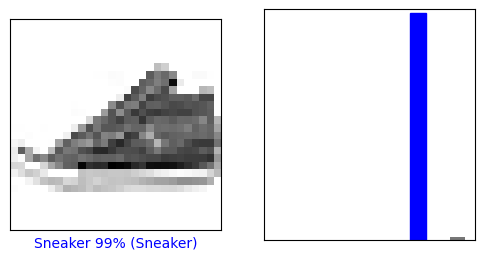

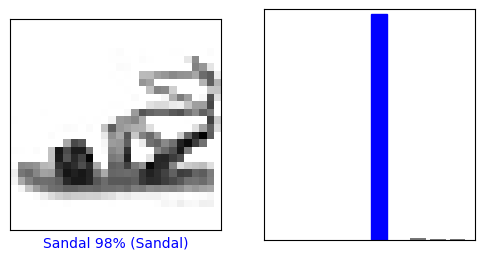

In [35]:
# Predictions of the batch
# i = BATCH_SIZE
for i in range (0, BATCH_SIZE):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(1,2,2)
  plot_value_array(i, predictions, test_labels)

### Predict the single image

In [36]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [37]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [38]:
# Do the prediction
predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 52ms/step
[[6.4187254e-05 4.3597820e-06 3.3159949e-02 5.5173546e-06 9.1514391e-01
  1.8070645e-08 5.1607545e-02 4.2202810e-08 1.4553133e-05 2.5123934e-09]]


In [41]:
# Select the class
print(class_names[np.argmax(predictions_single)])

Coat


# Exercises

## ***Exercise 1***
### Set epch size to 1

In [8]:
# Bulding the seqential model using dense layers
# Using ReLU as activation function (Best for non-linear algos)
# Softmax has chosen for output activation function

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Adam Optimizer is used
# Loss functions for classification is selected as sparse_categorical_crossentropy
# And the perfromance is evaluated on the accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# To train the model batch size should be defined
# In this case it is 32
BATCH_SIZE = 32

# Train dataset
# Caches use for faster training
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
# Test dataset
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

# Fit the model
model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

1875/1875 [==============================] - 18s 4ms/step - loss: 0.4921 - accuracy: 0.8275


As we can see accuracy is lesser than 5 epoch size

## ***Exercise 2***
### Change the size of Dense layer

In [12]:
# Bulding the seqential model using dense layers
# Using ReLU as activation function (Best for non-linear algos)
# Softmax has chosen for output activation function

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Adam Optimizer is used
# Loss functions for classification is selected as sparse_categorical_crossentropy
# And the perfromance is evaluated on the accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# To train the model batch size should be defined
# In this case it is 32
BATCH_SIZE = 32

# Train dataset
# Caches use for faster training
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
# Test dataset
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

# Fit the model
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 11s 3ms/step - loss: 0.4723 - accuracy: 0.8318
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3567 - accuracy: 0.8691
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3185 - accuracy: 0.8826
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2962 - accuracy: 0.8897
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2824 - accuracy: 0.8952


Accuracy is almost 90% when increasing the number of Neurons

## ***Exercise 3***
### Add additional layer

In [16]:
# Bulding the seqential model using dense layers
# Using ReLU as activation function (Best for non-linear algos)
# Softmax has chosen for output activation function

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Adam Optimizer is used
# Loss functions for classification is selected as sparse_categorical_crossentropy
# And the perfromance is evaluated on the accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# To train the model batch size should be defined
# In this case it is 32
BATCH_SIZE = 32

# Train dataset
# Caches use for faster training
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
# Test dataset
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

# Fit the model
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 13s 3ms/step - loss: 0.4714 - accuracy: 0.8298
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3585 - accuracy: 0.8675
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3198 - accuracy: 0.8811
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3007 - accuracy: 0.8879
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2815 - accuracy: 0.8940


Performace has increased than the basic model

## ***Exercise 4***
### Without normalizing

In [18]:
# Bulding the seqential model using dense layers
# Using ReLU as activation function (Best for non-linear algos)
# Softmax has chosen for output activation function

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Adam Optimizer is used
# Loss functions for classification is selected as sparse_categorical_crossentropy
# And the perfromance is evaluated on the accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# To train the model batch size should be defined
# In this case it is 32
BATCH_SIZE = 32

# Train dataset
# Caches use for faster training
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
# Test dataset
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

# Fit the model
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 13s 4ms/step - loss: 3.5502 - accuracy: 0.7037
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6786 - accuracy: 0.7590
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5903 - accuracy: 0.7893
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5506 - accuracy: 0.8097
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5263 - accuracy: 0.8233


In [21]:
# Doing the prediction
test_image = test_images[0]

# Add it to the batch
test_image = np.array([test_image])

# Test prediction
test_prediction = model.predict(test_image)

# True label
print(f"True class = {class_names[test_labels[0]]}")
print(f"Predicted class = {class_names[np.argmax(test_prediction)]}")

1/1 [==============================] - 0s 48ms/step
True class = Coat
Predicted class = Coat


In [23]:
print(test_prediction)

[[4.2471816e-05 1.4644785e-05 6.2540159e-02 6.6954334e-04 9.0624434e-01
  4.2087041e-18 3.0487083e-02 2.3513371e-37 1.7915830e-06 0.0000000e+00]]


As we can see here there is no effect without normalizing.